# RAFT Optical Flow Estimation with OpenVINO™

This tutorial explains converting the RAFT ONNX\* model with OpenVNO and provides the image and video inference demo.

This tutorial demonstrates step-by-step instructions on how to run RAFT with OpenVINO based on the [ONNX-RAFT-Optical-Flow-Estimation](https://github.com/ibaiGorordo/ONNX-RAFT-Optical-Flow-Estimation/tree/main).

The tutorial consists of the following steps:

- Download the ONNX model
- Convert ONNX model to OpenVINO IR
- Evaluate the performance
- Test on images and video


## Get ONNX model

Here we choose the model for the SINTEL dataset with input size 360x480 and iteration times 20.


In [5]:
import sys
import tarfile
from pathlib import Path

sys.path.append("../utils")
import notebook_utils as utils

ITER = "iter20"
ARCHIVE = "resources.tar.gz"
model_url = f"https://s3.ap-northeast-2.wasabisys.com/pinto-model-zoo/252_RAFT/{ITER}/{ARCHIVE}"
base_model_dir = Path("models")
downloaded_model_path = base_model_dir / Path(ARCHIVE)

if not downloaded_model_path.exists():
    utils.download_file(model_url, downloaded_model_path.name, downloaded_model_path.parent)

model_onnx_path = base_model_dir / Path("raft_sintel_iter20_360x480.onnx")

if not model_onnx_path.exists():
    with tarfile.open(downloaded_model_path) as file:
        file.extractall(base_model_dir)

## Convert model to OpenVINO IR.


In [6]:
from openvino.runtime import serialize
from openvino.tools.mo import convert_model

model_ov_path = model_onnx_path.with_suffix(".xml")

if not model_ov_path.exists():
    ov_model = convert_model(model_onnx_path, compress_to_fp16=True)
    serialize(ov_model, xml_path=str(model_ov_path))
else:
    print("OpenVINO IR already converted")

OpenVINO IR already converted


## Evaluate the performance

Use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance on CPU.


In [1]:
!benchmark_app -m {model_ov_path} -d CPU -niter 2

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] Device info:
[ INFO ] CPU
[ INFO ] Build ................................. 2022.3.0-9052-9752fafe8eb-releases/2022/3
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(CPU) performance hint will be set to THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ ERROR ] Model file /home/yangsu/workspace/my_openvino_notebooks/openvino_notebooks/notebooks/210-raft-optical-flow/{model_ov_path} cannot be opened!
Traceback (most recent call last):
  File "/home/yangsu/anaconda3/envs/py39notebook/lib/python3.9/site-packages/openvino/tools/benchmark/main.py", line 368, in main
    model = benchmark.read_model(args.path_to_model)
  File "/h

## Test on images

Load the model with model caching.


In [8]:
from openvino.runtime import Core

core = Core()
core.set_property({"CACHE_DIR": ".cache"})

model_ov = core.read_model(model=model_ov_path)
compiled_model = core.compile_model(model=model_ov, device_name="CPU")

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(1)

N, C, H, W = input_layer.shape

Download two KITTI frames and do pre-processing.


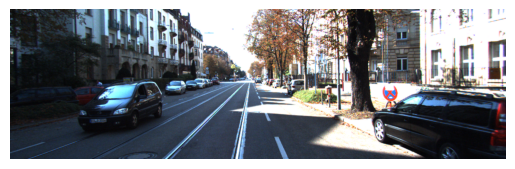

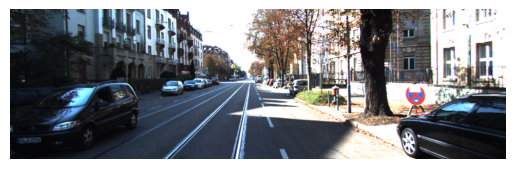

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def prepare_input(img: np.ndarray, w: int, h: int):
    """
    pre-processing: resize, transpose and set data type
    :param img (np.ndarray): input image
    :param W: width of model input
    :param H: height of model input
    :return img_input.astype(np.float32) (np.ndarray)
    """
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    img_input = cv2.resize(img, (w, h))
    img_input = img_input.transpose(2, 0, 1)
    img_input = img_input[np.newaxis, :, :, :]

    return img_input.astype(np.float32)


IMAGE_PATH_1 = "../data/image/kitti_1.png"
IMAGE_PATH_2 = "../data/image/kitti_2.png"


if not Path(IMAGE_PATH_1).exists():
    IMG_URL_1 = "https://raw.githubusercontent.com/liruoteng/OpticalFlowToolkit/master/data/example/KITTI/frame1.png"
    IMG_URL_2 = "https://raw.githubusercontent.com/liruoteng/OpticalFlowToolkit/master/data/example/KITTI/frame2.png"

    downloaded_path_1 = Path(IMAGE_PATH_1)
    downloaded_path_2 = Path(IMAGE_PATH_2)
    utils.download_file(IMG_URL_1, downloaded_path_1.name, downloaded_path_1.parent)
    utils.download_file(IMG_URL_2, downloaded_path_2.name, downloaded_path_2.parent)

img1 = np.array(Image.open(IMAGE_PATH_1), dtype=np.uint8)
img2 = np.array(Image.open(IMAGE_PATH_2), dtype=np.uint8)
input_tensor1 = prepare_input(img1, W, H)
input_tensor2 = prepare_input(img2, W, H)

Do Inference.


In [10]:
result = compiled_model([input_tensor1, input_tensor2])[compiled_model.output(1)]
flow_map_ov = result[0].transpose(1, 2, 0)

Post-processing:

Utils function for transferring flow to Middlebury color code image from [OpticalFlowToolkit](https://github.com/liruoteng/OpticalFlowToolkit/blob/5cf87b947a0032f58c922bbc22c0afb30b90c418/lib/flowlib.py#L249).


In [11]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col : col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / YG))
    colorwheel[col : col + YG, 1] = 255
    col += YG

    # GC
    colorwheel[col : col + GC, 1] = 255
    colorwheel[col : col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col : col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / CB))
    colorwheel[col : col + CB, 2] = 255
    col += CB

    # BM
    colorwheel[col : col + BM, 2] = 255
    colorwheel[col : col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
    col += +BM

    # MR
    colorwheel[col : col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col : col + MR, 0] = 255

    return colorwheel


colorwheel = make_color_wheel()


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2 + v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a + 1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols + 1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel, 1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0 - 1] / 255
        col1 = tmp[k1 - 1] / 255
        col = (1 - f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1 - rad[idx] * (1 - col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col * (1 - nanIdx)))

    return img


def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.0
    maxv = -999.0
    minu = 999.0
    minv = 999.0

    UNKNOWN_FLOW_THRESH = 1e7

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u**2 + v**2)
    maxrad = max(-1, np.max(rad))

    u = u / (maxrad + np.finfo(float).eps)
    v = v / (maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

Define functions for visualizing the flow image and arrow image with matplotlib quiver.


In [12]:
def draw_flow(flow_map: np.ndarray, ori_width: int, ori_height: int):
    """
    Convert flow into middlebury color code image and resize
    :param flow_map: the model inference result
    :param ori_width: the original image width
    :param ori_height: the original height
    :return resized_img: resized flow image
    """
    flow_img = flow_to_image(flow_map)
    flow_img = cv2.cvtColor(flow_img, cv2.COLOR_RGB2BGR)
    resized_img = cv2.resize(flow_img, (ori_width, ori_height))
    return resized_img


def visualize_arrow(origin_img: np.ndarray, flow_map: np.ndarray):
    """
    visualize the flow map with 2D field of arrows via matplotlib.pyplot.quiver
    :param origin_img: original KITTI frame
    :param flow_map: the inference result
    """
    img_height = origin_img.shape[:2][0]
    img_width = origin_img.shape[:2][1]
    flow_img = cv2.resize(flow_map, (img_width, img_height))
    num = 30
    x, y = np.meshgrid(
        np.arange(0, img_height, num, dtype=int),
        np.arange(0, img_width, num, dtype=int),
    )
    u = flow_img[:, :, 0]
    v = flow_img[:, :, 1]
    U = u[x, y]
    V = -v[x, y]

    plt.imshow(origin_img)
    plt.quiver(y, x, U, V, np.hypot(U, V))
    plt.title("arrow_img")
    plt.axis("off")
    plt.show()


def visualize_flow_img(origin_img, flow_img):
    """
    visualize the resized flow image with mask
    :param origin_img: original KITTI frame
    :param flow_map: the resized flow image
    """
    alpha = 0.5
    masked_img = cv2.addWeighted(origin_img, alpha, flow_img, (1 - alpha), 0)
    return masked_img

### Run image inference


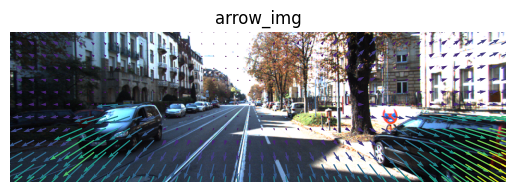

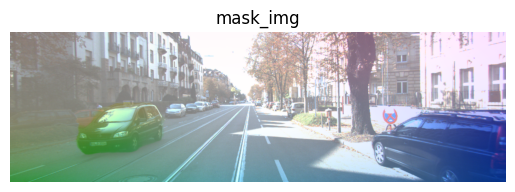

In [13]:
visualize_arrow(img1, flow_map_ov)

img1_height = img1.shape[:2][0]
img1_width = img1.shape[:2][1]
flow_img_ov = draw_flow(flow_map_ov, img1_width, img1_height)
mask_img = visualize_flow_img(img1, flow_img_ov)
plt.imshow(mask_img)
plt.title("mask_img")
plt.axis("off")
plt.show()

Use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance on CPU.


In [14]:
!benchmark_app -m {model_ov_path} -d CPU -niter 2

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
usage: benchmark_app [-h [HELP]] [-i PATHS_TO_INPUT [PATHS_TO_INPUT ...]] -m
                     PATH_TO_MODEL [-d TARGET_DEVICE] [-extensions EXTENSIONS]
                     [-c PATH_TO_CLDNN_CONFIG]
                     [-hint {throughput,cumulative_throughput,latency,none}]
                     [-api {sync,async}] [-niter NUMBER_ITERATIONS]
                     [-nireq NUMBER_INFER_REQUESTS] [-b BATCH_SIZE] [-t TIME]
                     [-shape SHAPE] [-data_shape DATA_SHAPE] [-layout LAYOUT]
                     [-nstreams NUMBER_STREAMS]
                     [-latency_percentile LATENCY_PERCENTILE]
                     [-nthreads NUMBER_THREADS]
                     [-pin {YES,NO,NUMA,HYBRID_AWARE}]
                     [-exec_graph_path EXEC_GRAPH_PATH] [-pc [PERF_COUNTS]]
                     [-pcsort {no_sort,sort,simple_sort}] [-pcseq [PCSEQ]]
                     [-inference_only [INFERENC

## Test on video

### Prerequisites

Install imageio for generating GIF.


In [15]:
!pip install imageio

In [16]:
# import notebook_utils as utils
import collections
import sys
import time

import imageio
from IPython import display

# sys.path.append("../utils")

# Main processing function to run object detection.


def video_inference(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=10,
    model=model_ov,
    device="CPU",
):
    player = None

    compiled_model = core.compile_model(model, device)

    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        frames = []
        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()

            if frame is None:
                print("Source ended")
                break
            input_img_1 = np.array(frame)
            plt.imshow(input_img_1)
            plt.axis("off")
            plt.show()
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            input_img_2 = np.array(frame)

            Batch, Channel, height, width = compiled_model.input(0).shape

            input_tensor1 = prepare_input(input_img_1, width, height)
            input_tensor2 = prepare_input(input_img_2, width, height)

            start_time = time.time()

            result = compiled_model([input_tensor1, input_tensor2])[compiled_model.output(1)]

            flow_map_ov = result[0].transpose(1, 2, 0)

            stop_time = time.time()

            input_img_1_height = input_img_1.shape[:2][0]
            input_img_1_width = input_img_1.shape[:2][1]
            flow_img_ov = draw_flow(flow_map_ov, input_img_1_width, input_img_1_height)
            output_frame = visualize_flow_img(input_img_1, flow_img_ov)
            frames.append(output_frame)
            # frame = input_img_1
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = output_frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=output_frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=output_frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(
                    ext=".jpg",
                    img=output_frame,
                    params=[cv2.IMWRITE_JPEG_QUALITY, 1000],
                )
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=False)
                display.display(i)
        print("Saving GIF file")
        with imageio.get_writer("test.gif", mode="I") as writer:
            for idx, frame in enumerate(frames):
                # print("Adding frame to GIF file: ", idx + 1)
                rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                writer.append_data(rgb_frame)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run video inference

Use the video as the video input.


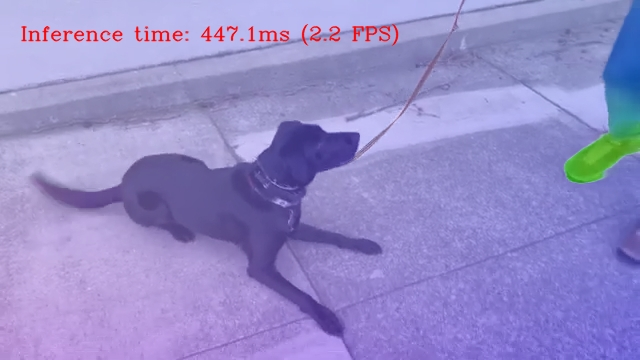

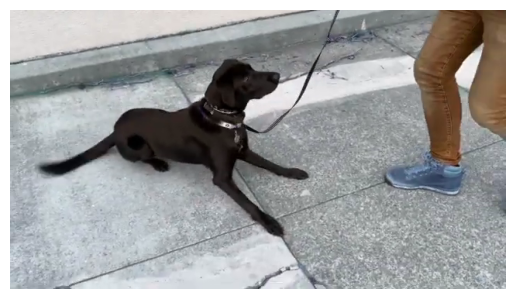

Source ended
Saving GIF file


In [17]:
video_inference(
    source="../data/video/Coco Walking in Berkeley.mp4",
    flip=False,
    use_popup=False,
    model=model_ov,
    device="CPU",
)

Use a webcam as the video input.

> **NOTE**: Run live inference. By default, the primary webcam is set with `source=0`. If you have multiple webcams, each one will be assigned a consecutive number starting at 0. Set `flip=True` when using a front-facing camera. Some web browsers, especially Mozilla Firefox, may cause flickering. If you experience flickering, set `use_popup=True`. To use this notebook with a webcam, you need to run the notebook on a computer with a webcam. If you run the notebook on a server (for example, Binder), the webcam will not work. Popup mode may not work if you run this notebook on a remote computer (for example, Binder).


In [18]:
video_inference(source=0, flip=False, use_popup=False, model=model_ov, device="CPU")

Cannot open camera 0


[ WARN:0@39.659] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@39.659] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


### References

1. RAFT: Recurrent All Pairs Field Transforms for Optical Flow (https://arxiv.org/pdf/2003.12039.pdf)
2. ONNX-RAFT-Optical-Flow-Estimation: https://github.com/ibaiGorordo/ONNX-RAFT-Optical-Flow-Estimation/tree/main

ONNX-RAFT-Optical-Flow-Estimation used in this notebook licensed under the MIT License. The license is displayed below: <br>
MIT License

Copyright (c) 2022 Ibai Gorordo

Permission is hereby granted, free of charge, to any person obtaining a copy<br>
of this software and associated documentation files (the "Software"), to deal<br>
in the Software without restriction, including without limitation the rights<br>
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell<br>
copies of the Software, and to permit persons to whom the Software is<br>
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all<br>
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR<br>
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,<br>
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE<br>
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER<br>
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,<br>
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE<br>
SOFTWARE.
